In [1]:
import os
import copy
import random
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_list = os.listdir(data_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.image_list[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        label = str(self.image_list[idx].split('_')[0])  # Extract the label from the filename
        if(label == "Shrek"): label = 0
        if(label == "GangDeRequin"): label = 1
        if(label == "Spiderman"): label = 2    
        if(label == "8miles"): label = 3

        return image, label

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to the required input size of your CNN
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the images
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize the images
])

In [4]:
data_folder = 'C:/Users/Vfarc/Desktop/Python/Cnn/data'

dataset = CustomDataset(data_folder, transform=transform)

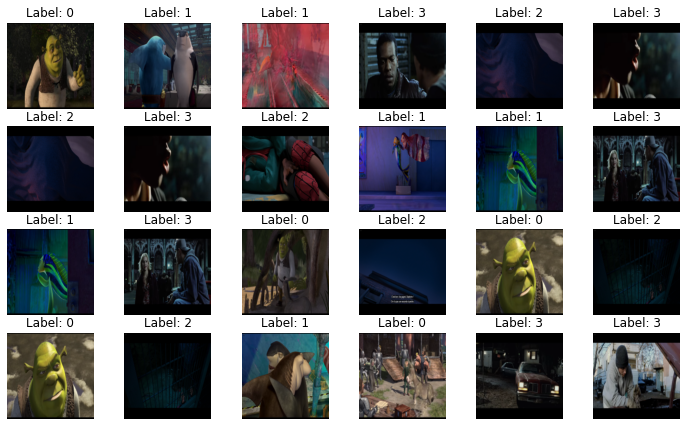

In [5]:
nrows=4
ncols=6
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4, 4))
sample = random.sample(range(len(dataset)), nrows*ncols)

for i in range(nrows):
    for j in range(ncols):
        image, label = dataset[sample[i*nrows+j]]
        image_np = image.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
        axs[i,j].imshow(image_np)
        axs[i,j].set_title(f"Label: {label}")
        axs[i,j].axis('off')


plt.subplots_adjust(left=None, bottom=None, right=2.5, top=1.5, wspace=0.2, hspace=None)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
num_epochs = 20
early_stopping = 5
batch_size = 128  

train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

train_data_loader = DataLoader(train_dataset, len(train_dataset))
test_data_loader = DataLoader(test_dataset, len(test_dataset))
batch_train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = Net()

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)

In [8]:
track_loss_train = []
track_loss_test = []
stopping_cond = False

for epoch in range(num_epochs):
    for batch_idx, data in enumerate(batch_train_data_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        (X, y), (X_test, y_test) = next(iter(train_data_loader)), next(iter(test_data_loader))
        track_loss_train.append(criterion(model(X), y).item())
        track_loss_test.append(criterion(model(X_test), y_test).item())
        
    if epoch >= early_stopping:
        if epoch == early_stopping:
            best_params = copy.deepcopy(model.state_dict())
        elif track_loss_test[epoch] < np.min(track_loss_test[early_stopping:epoch]):
            best_params = copy.deepcopy(model.state_dict())
    if early_stopping and (epoch > early_stopping):
        stopping_cond = np.min(track_loss_test[epoch - early_stopping:epoch + 1]) > np.min(track_loss_test[:epoch - early_stopping])

    if stopping_cond:
        print("/!\ Early Stopping")
        break

    if epoch % int(num_epochs/10) == 0:
        print("Epoch:", epoch)
        print("Train loss=", track_loss_train[epoch])
        print("Test loss=", track_loss_test[epoch])
        print("-" * 80)

Epoch: 0
Train loss= 0.684553861618042
Test loss= 0.7574825882911682
--------------------------------------------------------------------------------
Epoch: 2
Train loss= 0.5275551080703735
Test loss= 0.6189649105072021
--------------------------------------------------------------------------------
Epoch: 4
Train loss= 0.2893691658973694
Test loss= 0.5143865346908569
--------------------------------------------------------------------------------
Epoch: 6
Train loss= 0.2762547731399536
Test loss= 0.6472808122634888
--------------------------------------------------------------------------------
Epoch: 8
Train loss= 0.133972629904747
Test loss= 0.42761704325675964
--------------------------------------------------------------------------------
Epoch: 10
Train loss= 0.09154903888702393
Test loss= 0.5180495381355286
--------------------------------------------------------------------------------
Epoch: 12
Train loss= 0.05802084878087044
Test loss= 0.5294186472892761
---------------------

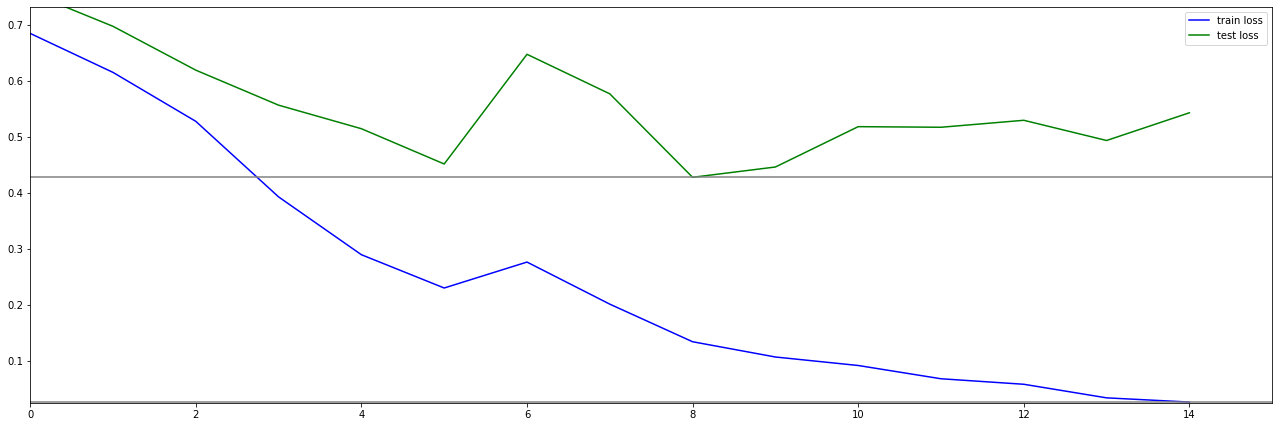

In [9]:
n_iter = len(track_loss_train)

plt.plot(np.arange(0,n_iter), track_loss_train, color = "blue", label="train loss")
plt.plot(np.arange(0,n_iter), track_loss_test, color = "green", label="test loss")
plt.xlim(0,n_iter)
plt.ylim(np.min(track_loss_train)*0.95,np.max(track_loss_test[n_iter//10:])*1.05)
plt.axhline(y=np.min(track_loss_train), color="grey")
plt.axhline(y=np.min(track_loss_test), color="grey")
plt.legend()


plt.subplots_adjust(left=None, bottom=None, right=3, top=1.5, wspace=0.2, hspace=None)

In [10]:
(X, y), (X_test, y_test) = next(iter(train_data_loader)), next(iter(test_data_loader))


best_rnn = Net()
best_rnn.load_state_dict(best_params)

Y_hat = best_rnn(X)
Y_hat_test = best_rnn(X_test)

print("Final results:\n")
print("Train loss:", criterion(Y_hat, y).item())
print("Test loss: ", criterion(Y_hat_test, y_test).item())

Final results:

Train loss: 0.133972629904747
Test loss:  0.42761704325675964


In [11]:
Y_hat_test  = nn.Softmax(dim=1)(Y_hat_test).detach()
y_hat_test = np.argmax(Y_hat_test, axis=1)

print(classification_report(y_test, y_hat_test, target_names = ["Shrek", "GangDeRequin", "Spiderman", "8miles"]))

              precision    recall  f1-score   support

       Shrek       0.74      0.79      0.76        47
GangDeRequin       0.81      0.75      0.78        56
   Spiderman       0.93      0.84      0.88        50
      8miles       0.88      0.97      0.92        61

    accuracy                           0.84       214
   macro avg       0.84      0.84      0.84       214
weighted avg       0.84      0.84      0.84       214



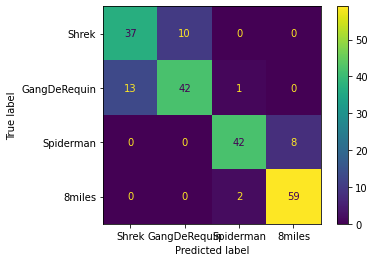

In [12]:
ConfusionMatrixDisplay.from_predictions(y_test, y_hat_test, 
                                        display_labels=["Shrek", "GangDeRequin", "Spiderman", "8miles"])

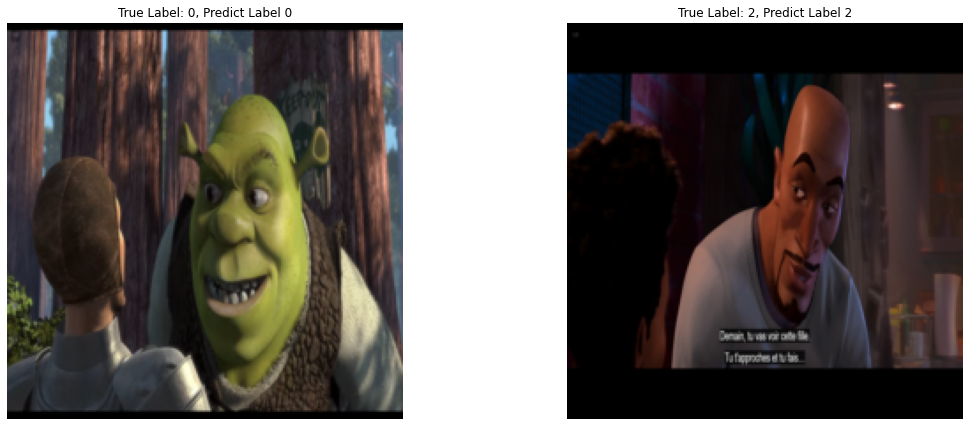

In [13]:
i,j = 12,13

fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2)

image, label, pred = X_test[i], y_test[i], y_hat_test[i]
image_np = image.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
ax0.imshow(image_np)
ax0.set_title(f"True Label: {label}, Predict Label {pred}")
ax0.axis('off')

image, label, pred = X_test[j], y_test[j], y_hat_test[j]
image_np = image.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
ax1.imshow(image_np)
ax1.set_title(f"True Label: {label}, Predict Label {pred}")
ax1.axis('off')

plt.subplots_adjust(left=None, bottom=None, right=2.5, top=1.5, wspace=0.2, hspace=None)
